In [20]:
from scipy import io
from scipy import sparse
from scipy import special
from scipy import linalg
from scipy import stats
import scipy as sp
import numpy as np
from time import time
import matplotlib.pylab as plt
from scipy.sparse import csr_matrix
import pylab as pb
import GPy
import math
import matplotlib.mlab as mlab
start = time()
import matplotlib.pylab as plt
from scipy.sparse import csr_matrix

In [21]:
names = ['apache 1','ecology 2', 'thermomech','shallow_water1','shallow_water2','finan512','jnlbrng1']
datasets = ['LogDet/apache1/apache1.mtx','LogDet/ecology2/ecology2.mtx','LogDet/thermomech_TC/thermomech_TC.mtx','LogDet/shallow_water1/shallow_water1.mtx','LogDet/shallow_water2/shallow_water2.mtx','LogDet/finan512/finan512.mtx','LogDet/jnlbrng1/jnlbrng1.mtx']
truths = [-3.2090e+05,-9.8767e+05,-2.2418e+05,-5.7151e+04,-9.1731e+04,-2.0942e+05,-5.3877e+04]

In [39]:
number = 2
print ('looking at dataset '+str(names[number]))
DATASET_ORIGINAL = datasets[number]

#number of random vectors to use
d = 50
#number of moments
m = 25


t0 = time()
h = []
suc = []
entropies = []
entropia = []
K = io.mmread(DATASET_ORIGINAL)
K2 = np.absolute(K)
eigmax = max(K2.sum(axis=1))
eigmax = float(eigmax)
#print eigmax
K = K/eigmax
w = []
print ('doing stochastic trace estimation')
print ('\n')
for i in range(0,d):
    v = []
    z = np.random.randn(K.shape[1]);
    z = z/np.sqrt(np.dot(z,z))
    M = K*np.transpose(z);
    for q in range(0,m):
        #v = np.append(np.dot(z,M),v)
        v.append(np.dot(z,M))
        M = K*M;
    w.append([v])
mu = []
f = 0
for j in range(0,m):
    k = []
    f = 0
    for i in range(0,d):
        f = f + w[i][0][j]/d
    mu.insert(d,f)
mu.insert(0,1)
chebmat = []
n = len(mu)
truth = truths[number]
print('normalised spectral moments')
print ('\n')
print(mu)
print ('\n')
print "Elapsed time:", 1000*(time()-t0), "ms"

looking at dataset thermomech
doing stochastic trace estimation


normalised spectral moments


[1, 0.1348387749297866, 0.025893958669609737, 0.0066205692594910395, 0.0020949289865094074, 0.0007746336462442948, 0.000321836692206884, 0.0001463124708515928, 7.142530692420415e-05, 3.691313799128742e-05, 1.9973385147425447e-05, 1.1216437855176535e-05, 6.491979118496467e-06, 3.851606866138846e-06, 2.3322782654408226e-06, 1.436553040406157e-06, 8.976456964642507e-07, 5.678173982099611e-07, 3.62991054530214e-07, 2.3419204684269663e-07, 1.5231871162702036e-07, 9.977946348810019e-08, 6.578171202587637e-08, 4.3618206792519925e-08, 2.907327206005336e-08, 1.9470729881384053e-08]


Elapsed time: 5264.63913918 ms


In [40]:
#Choose either Power moments 'power' or Chebyshev moments 'chebyshev'
#Chebyshev gives much more stable results for higher moment numbers

typec = 'chebyshev'

gridlength = 1e4+1
gmax = 1
gmin = 1e-5
lines = gridlength
x = np.linspace(gmin,gmax,lines)

if typec == 'power':

    v = np.diff(x)
    v = np.append(v,0)
    chebmat = []
    ler = []
    lerr = []
    err = []
    entr = []
    n = len(mu)
    u = [1]
    #running of algorithm for 2-n moments
    chebarray = []
    for i in range(0,n):
        q = x**i
        chebarray.insert(i,q)
    len(chebarray)

elif typec == 'chebyshev':
    v = np.diff(x)
    v = np.append(v,0)
    chebmat = []
    ler = []
    lerr = []
    err = []
    entr = []
    n = len(mu)
    u = [1]
    #conversion of power moments to Chebyshev moments
    for i in range(0,n):
        #print i
        cheb = np.polynomial.chebyshev.Chebyshev(u)
        coef = np.polynomial.chebyshev.cheb2poly(cheb.coef)
        j = i
        jj = i
        k = coef
        while (n-j-1>0):
            #print j
            k = np.append(k,0)
            j = j+1
        #print(coef)
        #print k
        chebmat.append(k)
        u.insert(0,0)
    chebmatrix = np.matrix(chebmat)
    inputs = (np.dot(chebmat,mu)+1)/2
    chebarray = []
    #running of algorithm for 2-n moments
    for i in range(0,n):
        q = ((special.eval_chebyt(i, x, out=None)+1)/2)
        chebarray.insert(i,q)



In [44]:
#NEW ALGORITHM DIFFERENT GRID 1/x for final calc
#numerical details, gridlength, xmax and xmin
err = []
ler = []
times = []
entr = []
floor = 1e-5
momnum = []

for ww in range(3,len(mu)):
    mu2 = []
    for b in range(0,ww):
        #for power moments use mu instead of inputs
        if (typec == 'power'):
            mu2.append(mu[b])
        else:
            mu2.append(inputs[b])
    #Note how the Chebyshev constraints are much more similar in Magnitude
    #print mu2
    #entropic functional
    def s(alpha):
        j = 1+np.dot(alpha,chebarray[:-(n-len(alpha))])
        q = np.exp(-j)
        u = (sum(q*v))+np.dot(mu2,alpha[:]);
        return u
    #gradient of S wrt alpha
    def grad(alpha):
        u = []
        j = []
        j = 1+np.dot(alpha,chebarray[:-(n-len(alpha))])
        q = np.exp(-j)
        u = mu2-np.dot(chebarray[:-(n-len(alpha))],(q*v))
        return np.asarray(u)
    #hessian
    def hessian(alpha):
        j = []
        j = 1+np.dot(alpha,chebarray[:-(n-len(alpha))])
        q = np.exp(-j)
        sd = np.array(chebarray[:-(n-len(alpha))])
        ass = np.einsum('j...,i...->ij...',sd,sd)
        ds = ass*q*v
        dss = np.sum(ds,axis=2)
        #Symmetrise and Add Jitter to improve Conditioning
        hdss = 0.5*(dss + dss.transpose())+1e-6*np.eye(len(alpha))
        return hdss
    #oprimization
    from scipy.optimize import minimize
    #do trust-ncg with grad and hess
    t0 = time()
    res = minimize(s, x0 = np.ones(len(mu2)), method = 'trust-ncg', jac=grad, hess=hessian, options={'gtol': 1e-5, 'disp': False, 'maxiter': None})
    #res = minimize(s, x0 = np.ones(len(mu2)), method = 'L-BFGS-B', jac=grad, options={'gtol': 1e-9, 'disp': True, 'maxiter': None})
    times.append(time()-t0)
#     print "Elapsed time:", 1000*(time()-t0), "ms"
    #using of results
    entropy = res.fun
    alpha = res.x
    #alpha = np.ones(m)    
    m = len(mu)
    j = 1;
    if (typec == 'power'):
        for i in range(0,ww):
        #use chebyt for chebyshev moments and x**i for power moments
        #j = j + alpha[i]*((special.eval_chebyt(i, xu, out=None)+1)/2)
            j = j + alpha[i]*x**i
    if (typec == 'chebyshev'):
        for i in range(0,ww):
        #use chebyt for chebyshev moments and x**i for power moments
            j = j + alpha[i]*((special.eval_chebyt(i, x, out=None)+1)/2)
    #print j
    p = 1/np.exp(j)
    #trace of inverse
    lest = (sum(p*np.log(x)*v)/sum(p*v))*M.shape[0]
    ldet = truth
    lerr = abs(ldet-lest)/abs(ldet)
    momnum.append(ww)
    ler.append(lerr)
    entr.append(entropy)
#plotting on a graph


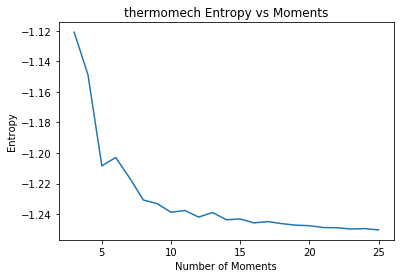

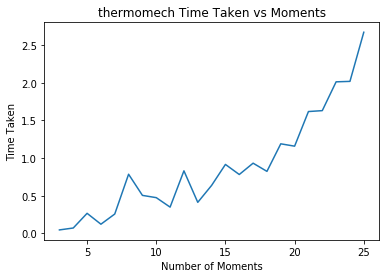

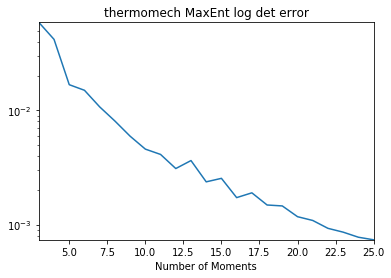

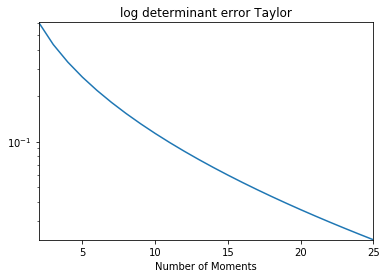

In [45]:
import matplotlib.pyplot as plt

plt.plot(momnum,entr)
plt.title(str(names[number])+' Entropy vs Moments')
plt.ylabel('Entropy')
plt.xlabel('Number of Moments')
plt.show()

plt.plot(momnum,times)
plt.title(str(names[number])+' Time Taken vs Moments')
plt.ylabel('Time Taken')
plt.xlabel('Number of Moments')
plt.show()

plt.plot(momnum,ler)
plt.title(str(names[number])+' MaxEnt log det error')
axes = plt.gca()
plt.yscale('log')
axes.set_ylim([min(ler),max(ler)])
axes.set_xlim([min(momnum),max(momnum)])
plt.xlabel('Number of Moments')
plt.show()

#Taylor Approx
#n = 100
nmat = K.shape[0]
momnum = []
errpoly = []
for ii in range(2,m):
    h = 0
    momnum.append(ii)
    for i in range(1,ii):
        q = ((-1)**(i+1)/float(i))
        #print 'q = '+str(q)
        w = 0
        for j in range(0,i+1):
            w = w + mu[j]*((-1)**(i-j))*sp.special.binom(i,j)
        #print 'w = '+str(w)
        h = h + q*w
        guess = (h*nmat)
        err = abs((ldet-(h*nmat))/ldet)
        #print guess
    errpoly.append(err)
plt.plot(momnum,errpoly)
plt.title('log determinant error Taylor')
axes = plt.gca()
plt.yscale('log')
axes.set_ylim([0,max(errpoly)])
axes.set_xlim([min(momnum),max(momnum)])
plt.xlabel('Number of Moments')
plt.show()